### Content
&#8544;. Read Data in<br>
&#8545;. Fetch Audio Features for Tracks from Spotify Web API<br>
&#8546;. Split Data into Train-Valid-Test sets<br>
&#8547;. Preprocess Data for Train-Valid sets<br>
&#8548;. Build Models with Random Forests & Neural Networks<br>
&#8549;. Test out Models on Test set<br>

# Prediction on Streams of Spotify's Worldwide Daily Most Listened Songs

<b>Goal:</b>
To build a random forests model and a neural networts model respectively to predict 'Streams' of Spotify's worldwide daily most listened songs.<br>
<b>Dataset:</b>
The daily 200 most listened songs in 53 countries from 2017 to 2018 by Spotify users. More descriptions of the dataset can be found <a href='https://www.kaggle.com/edumucelli/spotifys-worldwide-daily-song-ranking'>here</a>.<br>
<b>Basic Ideas:</b>
Explore & Preprocess data -> Build a random forests model for prediction & Update dataset by dropping columns of little importance with the help of variable importance scores -> Build a deep neural networks model for prediction with the updated datasets<br>
<b>Measures to Evaluate Models:</b>
R-Squared, Mean Squared Error<br>

In [1]:
"""Import necessary packages"""

import pandas as pd
import numpy as np
import spotipy
import spotipy.util as util
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score, mean_squared_error
# from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Using TensorFlow backend.


## &#8544;. Read Data in

In [2]:
%pwd

'/Users/gao.xiaob/Desktop/spotify'

In [3]:
# Current path
c_path = '/Users/gao.xiaob/Desktop/spotify'

In [4]:
df_data = pd.read_csv(f'{c_path}/data.csv', parse_dates=['Date'])

print(df_data.shape)
df_data.head()

(3441197, 7)


,Position,Track Name,Artist,Streams,URL,Date,Region
0,1,Reggaetón Lento (Bailemos),CNCO,19272,https://open.spotify.com/track/3AEZUABDXNtecAO...,2017-01-01,ec
1,2,Chantaje,Shakira,19270,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,2017-01-01,ec
2,3,Otra Vez (feat. J Balvin),Zion & Lennox,15761,https://open.spotify.com/track/3QwBODjSEzelZyV...,2017-01-01,ec
3,4,Vente Pa' Ca,Ricky Martin,14954,https://open.spotify.com/track/7DM4BPaS7uofFul...,2017-01-01,ec
4,5,Safari,J Balvin,14269,https://open.spotify.com/track/6rQSrBHf7HlZjtc...,2017-01-01,ec


In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3441197 entries, 0 to 3441196
Data columns (total 7 columns):
Position      int64
Track Name    object
Artist        object
Streams       int64
URL           object
Date          datetime64[ns]
Region        object
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 183.8+ MB


<i>From the outputs, we know that we are going to deal with a giant dataset, which contains more than 3 million rows of data. Even with such a giant dataset, however, it would still be hard to build a good machine learning model, since there are only 6 variables there for prediction and some variables like 'URL' actually have nothing to do with 'Streams'. As we all know, audio features of a song are what really matters when it comes to helping the song get popular and gain more streams. Therefore, instead of directly throwing 'URL' into our feature models, we could use 'URL' in a more meaningful way- to expend data features by fetching audio features for all the tracks from Spotify Web API.</i>

## &#8545;.  Fetch Audio Features for Tracks from Spotify Web API

<b>* This step shows every detail of how I fetched audio features for tracks from Spotify Web API. It would take hours to run through this step since Spotify allows us to fetch data for at most 50 tracks at a time. Data obtained from this step has been saved. We could move forward to step &#8546; directly if we do not want to get stuck here too long.</b>

In [7]:
"""
In order to use Spotify API to fetch data, we need to set our Spotify API credentials, 
which means to register an app on Spotify website first. I have done that outside the 
notebook, so now we have the needed environment variables, as below: 
    SPOTIPY_CLIENT_ID='9b89bceb41094be298505c3970a11bcc'
    SPOTIPY_CLIENT_SECRET='bbfd5570092b4e09b88e83e744f7e848'
    SPOTIPY_REDIRECT_URI='http://google.com/'
"""

"""
Spotify would give their users instant IDs when requested. Remember that those IDs will 
be valid only for an hour. To request your instant ID: 
    go to Spotify player-> log in your Spotify account-> click on your profile image
    -> get an ID by clicking 'Copy Profile Link' under '...'
"""

# Here's my instant profile link: 
# https://open.spotify.com/user/31z2m2i3pqszfsroulu63g7bc3hu?si=mNaSr09NTv6ToiRn33VmSQ
user_id = '31z2m2i3pqszfsroulu63g7bc3hu?si=mNaSr09NTv6ToiRn33VmSQ'
token = util.prompt_for_user_token(user_id, 
                                   client_id='9b89bceb41094be298505c3970a11bcc', 
                                   client_secret='bbfd5570092b4e09b88e83e744f7e848',
                                   redirect_uri='http://google.com/')
spotify_obj = spotipy.Spotify(auth=token)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=9b89bceb41094be298505c3970a11bcc&response_type=code&redirect_uri=http%3A%2F%2Fgoogle.com%2F in your browser


Enter the URL you were redirected to: https://www.google.com/?code=AQCt6RFtVMkNS1mhQv08J2FPCUmiayxD3TRiIQXxs_-lxLneVBy_o-lEjn3eexBxnSh-dmlMPG-D9G1pzo8Sxcvw744i-duSvTaTPr-axbIClhXR7ZwS0mUReT0N3gH7K04xvMD1zTZV6IK9CikCghErdzWdJC_2pHQoSPziDX_-VK_ppHDH8qQO




In [8]:
"""Fetch audio features for a track with its url and have a
general picture of what audio features there are"""

# Get url of the first track
url = df_data['URL'][0]

# Fetch audio features of the first track
spotify_obj.audio_features(url)

[{'danceability': 0.761,
  'energy': 0.838,
  'key': 4,
  'loudness': -3.073,
  'mode': 0,
  'speechiness': 0.0502,
  'acousticness': 0.4,
  'instrumentalness': 0,
  'liveness': 0.176,
  'valence': 0.71,
  'tempo': 93.974,
  'type': 'audio_features',
  'id': '3AEZUABDXNtecAOSC1qTfo',
  'uri': 'spotify:track:3AEZUABDXNtecAOSC1qTfo',
  'track_href': 'https://api.spotify.com/v1/tracks/3AEZUABDXNtecAOSC1qTfo',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/3AEZUABDXNtecAOSC1qTfo',
  'duration_ms': 222560,
  'time_signature': 4}]

<i>For more information of what these audio feature names stand for, check <a href='https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/'>this</a> out.</i>

In [9]:
# Check how many NaNs there are
df_data.isnull().sum()

Position        0
Track Name    657
Artist        657
Streams         0
URL             8
Date            0
Region          0
dtype: int64

<i>From the output, we know that there are 8 NaNs in the 'URL' column. If we try to use these NaNs as URLs to fetch data with Spotify API, errors would be thrown. We thus have to deal with NaNs for the 'URL' column first.</i>

In [10]:
# Replace NaNs with ''
df_data_2 = df_data.fillna(value={'URL': ''})

df_data_2.isnull().sum()

Position        0
Track Name    657
Artist        657
Streams         0
URL             0
Date            0
Region          0
dtype: int64

In [11]:
"""Fetch audio features for all tracks"""

audio_features = []
for i in range(0, len(df_data), 50):
    if i == 0:
        print("Fetching audio features...")
        print()
    while True:
        try:
            # Spotify API allows at most 50 tracks to fetch audio features at a time
            audio_features += spotify_obj.audio_features(df_data_2['URL'][i:i+50].values.tolist())
            if i % 300000 == 0 and i != 0:
                print(f"Done for {i} tracks!")
            break
        except:
            print()
            # Get user ID renewed when it's expired in a hour
            user_id = input("Enter new user ID to get access token refreshed: ")
            token = util.prompt_for_user_token(user_id, 
                                            client_id='9b89bceb41094be298505c3970a11bcc', 
                                            client_secret='bbfd5570092b4e09b88e83e744f7e848',
                                            redirect_uri='http://google.com/')
            spotify_obj = spotipy.Spotify(auth=token)
print()
print("Done for all tracks!")

Fetching audio features...

Done for 300000 tracks!
Done for 600000 tracks!
Done for 900000 tracks!
Done for 1200000 tracks!

Enter new user ID to get access token refreshed: 31z2m2i3pqszfsroulu63g7bc3hu?si=UZ7ZAHv8QQumHpKFKf_TkQ


            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=9b89bceb41094be298505c3970a11bcc&response_type=code&redirect_uri=http%3A%2F%2Fgoogle.com%2F in your browser


Enter the URL you were redirected to: https://www.google.com/?code=AQAPSrBU6iwO8_gXf0K_-TkbK22lsX7Xdp3qifGX6nJFq3U7vc00fjFMnuYOdugUmU79-QoUf212sDDaLn9iGkbN7dR7vvz_TxMwVC2b-6WIJ4bGF9v0gdG3wN6GWCEnd7a6RL3s0bqCPanzPzcru8MmNw4rkIkF73HRoEZc62TzOSPztVYV4umW


Done for 1500000 tracks!
Done for 1800000 tracks!
Done fo

In [12]:
"""We got None objects in audio_feature when URLs were invalid. 
Those Nones would be big trouble if we constructed a DataFrame 
object with audio_feature directly. So replace them first"""

# Replace None in audio_features with {}
audio_features_2 = [{} if item is None else item for item in audio_features]

In [13]:
# Construct a DataFrame object with audio_feature_2
df_audio_features = pd.DataFrame(audio_features_2)

print(df_audio_features.shape)
df_audio_features.head()

(3441197, 18)


,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.40000,https://api.spotify.com/v1/audio-analysis/3AEZ...,0.761,222560.0,0.838,3AEZUABDXNtecAOSC1qTfo,0.000000,4.0,0.176,-3.073,0.0,0.0502,93.974,4.0,https://api.spotify.com/v1/tracks/3AEZUABDXNte...,audio_features,spotify:track:3AEZUABDXNtecAOSC1qTfo,0.710
1,0.18700,https://api.spotify.com/v1/audio-analysis/6mIC...,0.852,195840.0,0.773,6mICuAdrwEjh6Y6lroV2Kg,0.000030,8.0,0.159,-2.921,0.0,0.0776,102.034,4.0,https://api.spotify.com/v1/tracks/6mICuAdrwEjh...,audio_features,spotify:track:6mICuAdrwEjh6Y6lroV2Kg,0.907
2,0.05590,https://api.spotify.com/v1/audio-analysis/3QwB...,0.832,209453.0,0.772,3QwBODjSEzelZyVjxPOHdq,0.000486,10.0,0.440,-5.429,1.0,0.1000,96.016,4.0,https://api.spotify.com/v1/tracks/3QwBODjSEzel...,audio_features,spotify:track:3QwBODjSEzelZyVjxPOHdq,0.704
3,0.00431,https://api.spotify.com/v1/audio-analysis/7DM4...,0.663,259196.0,0.920,7DM4BPaS7uofFul3ywMe46,0.000017,11.0,0.101,-4.070,0.0,0.2260,99.935,4.0,https://api.spotify.com/v1/tracks/7DM4BPaS7uof...,audio_features,spotify:track:7DM4BPaS7uofFul3ywMe46,0.533
4,0.55100,https://api.spotify.com/v1/audio-analysis/6rQS...,0.508,205600.0,0.687,6rQSrBHf7HlZjtcMZ4S4bO,0.000003,0.0,0.126,-4.361,1.0,0.3260,180.044,4.0,https://api.spotify.com/v1/tracks/6rQSrBHf7HlZ...,audio_features,spotify:track:6rQSrBHf7HlZjtcMZ4S4bO,0.555


In [14]:
"""Save audio features as CSV to current path"""  

df_audio_features.to_csv(f'{c_path}/audio_features.csv')

## &#8546;. Split Data into Train-Valid-Test Sets

In [11]:
"""Read data in again & Integrate audio features into the original dataset. 
we will be only using the integrated dataset from here throughout to the end"""

df_af = pd.read_csv(f'{c_path}/audio_features.csv', index_col=0)
df_data_with_af = pd.concat([df_data, df_af], axis=1)
df_data_with_af.sort_values(by=['Date', 'Region'], inplace=True)

print(df_data_with_af.shape)
df_data_with_af.head(3)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(3441197, 25)


,Position,Track Name,Artist,Streams,URL,Date,Region,acousticness,analysis_url,danceability,...,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
148400,1,Chantaje,Shakira,253019,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,2017-01-01,ar,0.18700,https://api.spotify.com/v1/audio-analysis/6mIC...,0.852,...,0.159,-2.921,0.0,0.0776,102.034,4.0,https://api.spotify.com/v1/tracks/6mICuAdrwEjh...,audio_features,spotify:track:6mICuAdrwEjh6Y6lroV2Kg,0.907
148401,2,Vente Pa' Ca,Ricky Martin,223988,https://open.spotify.com/track/7DM4BPaS7uofFul...,2017-01-01,ar,0.00431,https://api.spotify.com/v1/audio-analysis/7DM4...,0.663,...,0.101,-4.070,0.0,0.2260,99.935,4.0,https://api.spotify.com/v1/tracks/7DM4BPaS7uof...,audio_features,spotify:track:7DM4BPaS7uofFul3ywMe46,0.533
148402,3,Reggaetón Lento (Bailemos),CNCO,210943,https://open.spotify.com/track/3AEZUABDXNtecAO...,2017-01-01,ar,0.40000,https://api.spotify.com/v1/audio-analysis/3AEZ...,0.761,...,0.176,-3.073,0.0,0.0502,93.974,4.0,https://api.spotify.com/v1/tracks/3AEZUABDXNte...,audio_features,spotify:track:3AEZUABDXNtecAOSC1qTfo,0.710


In [12]:
"""In order to go through every step needed to build machine learning models, 
we will be using a subset of df_data_with_af. This is totally out of consideration
of running speed. Comment codes in this box if we want to see what would be like 
with the whole dataset."""

df_data_with_af = df_data_with_af[:441197]

print(df_data_with_af.shape)

(441197, 25)


In [13]:
"""Seperate out X and y"""

y_data_with_af = df_data_with_af['Streams']
X_data_with_af = df_data_with_af.drop(['Streams'], axis=1)

print(X_data_with_af.shape, y_data_with_af.shape)

(441197, 24) (441197,)


In [14]:
"""Split data into train-valid set and test set"""

(X_train_valid, X_test, y_train_valid, y_test) = train_test_split(X_data_with_af, 
                                                                  y_data_with_af, 
                                                                  test_size=0.12, 
                                                                  shuffle=False)

print('Shape:')
print('Train-Valid Set -', X_train_valid.shape, y_train_valid.shape)
print('Test Set -', X_test.shape, y_test.shape)

Shape:
Train-Valid Set - (388253, 24) (388253,)
Test Set - (52944, 24) (52944,)


## &#8547;. Preprocess Data for Train-Valid Sets

In [15]:
"""Define some functions for data preprocessing for later use"""

def split_date(df, date_column):
    """Function to split df[date_column] into four other date relevant columns
       df: a DataFrame object
       data_column: name of the column with datetime64 dtype - str
    """
    df = df.copy()
    date_df = pd.DataFrame({"year": df[date_column].dt.year,
                            "month": df[date_column].dt.month,
                            "day": df[date_column].dt.day,
                            "dayofweek": df[date_column].dt.dayofweek,
             })
    df = df.drop(date_column, axis=1)
    df = pd.concat([df, date_df], axis=1)
    return df

def convert_cat_to_num(df, feature, mapping=None):
    """Function to convert object dtype data in df[feature] to numerical values
       df: a DateFrame object
       feature: a feature of the df - str
       mapping: categories and their mapping values - None/dict 
    """
    df = df.copy()
    cats_list = df[feature].astype('category').cat.categories.tolist()
    if mapping is None:
        mapping = {k: v for k, v in zip(cats_list, list(range(1, len(cats_list) + 1)))}
        
    else:
        new_cats_list = []
        for c in cats_list:
            if c not in mapping:
                new_cats_list.append(c)
        start = len(mapping) + 1
        mapping.update({k: v for k, v in zip(new_cats_list, list(range(start, len(new_cats_list) + start)))})
                                    
    df[feature] = df[feature].map(mapping)
    return df, mapping   

In [16]:
"""Drop columns that intuitively have nothing to do with Streams- We also throw 
the 'Position' column since 'Position' is the ranking of tracks, which won't be 
known until 'Streams' is available"""

X_train_valid_2 = X_train_valid.drop(['Position', 'URL', 'analysis_url', 'id', 'track_href', 'type', 'uri'], axis=1)

In [17]:
"""Split 'Data' column"""

X_train_valid_3 = split_date(X_train_valid_2, 'Date')

X_train_valid_3.tail(3)

,Track Name,Artist,Region,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,year,month,day,dayofweek
2445477,This Girl (Kungs Vs. Cookin' On 3 Burners) - K...,Kungs,es,0.0800,0.793,195547.0,0.729,0.000031,0.0,0.317,-4.770,0.0,0.0394,121.972,4.0,0.488,2017,2,13,0
2445478,Bounce Back,Big Sean,es,0.1050,0.770,222360.0,0.567,0.000000,2.0,0.125,-5.698,1.0,0.1750,81.477,4.0,0.260,2017,2,13,0
2445479,"Herman’s Habit - From ""La La Land"" Soundtrack",Justin Hurwitz,es,0.0502,0.568,111600.0,0.577,0.925000,8.0,0.125,-10.442,1.0,0.0497,123.948,4.0,0.572,2017,2,13,0


In [18]:
X_train_valid_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388253 entries, 148400 to 2445479
Data columns (total 20 columns):
Track Name          388253 non-null object
Artist              388253 non-null object
Region              388253 non-null object
acousticness        388251 non-null float64
danceability        388251 non-null float64
duration_ms         388251 non-null float64
energy              388251 non-null float64
instrumentalness    388251 non-null float64
key                 388251 non-null float64
liveness            388251 non-null float64
loudness            388251 non-null float64
mode                388251 non-null float64
speechiness         388251 non-null float64
tempo               388251 non-null float64
time_signature      388251 non-null float64
valence             388251 non-null float64
year                388253 non-null int64
month               388253 non-null int64
day                 388253 non-null int64
dayofweek           388253 non-null int64
dtypes: float6

In [19]:
"""Convert data of object dtype to numerical values"""

X_train_valid_4, track_name_map = convert_cat_to_num(X_train_valid_3, 'Track Name')
X_train_valid_4, artist_map = convert_cat_to_num(X_train_valid_4, 'Artist')
X_train_valid_4, region_map = convert_cat_to_num(X_train_valid_4, 'Region')

X_train_valid_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388253 entries, 148400 to 2445479
Data columns (total 20 columns):
Track Name          388253 non-null int64
Artist              388253 non-null int64
Region              388253 non-null int64
acousticness        388251 non-null float64
danceability        388251 non-null float64
duration_ms         388251 non-null float64
energy              388251 non-null float64
instrumentalness    388251 non-null float64
key                 388251 non-null float64
liveness            388251 non-null float64
loudness            388251 non-null float64
mode                388251 non-null float64
speechiness         388251 non-null float64
tempo               388251 non-null float64
time_signature      388251 non-null float64
valence             388251 non-null float64
year                388253 non-null int64
month               388253 non-null int64
day                 388253 non-null int64
dayofweek           388253 non-null int64
dtypes: float64(1

In [20]:
X_train_valid_4.isnull().sum()

Track Name          0
Artist              0
Region              0
acousticness        2
danceability        2
duration_ms         2
energy              2
instrumentalness    2
key                 2
liveness            2
loudness            2
mode                2
speechiness         2
tempo               2
time_signature      2
valence             2
year                0
month               0
day                 0
dayofweek           0
dtype: int64

In [21]:
"""Deal with NaNs"""

X_train_valid_5 = X_train_valid_4.fillna(0)

In [22]:
"""Standardize continuous variables"""

# scaler = MinMaxScaler()
scaler = StandardScaler()

con_cols = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']
X_train_valid_5[con_cols] = scaler.fit_transform(X_train_valid_5[con_cols])

X_train_valid_5.head()

,Track Name,Artist,Region,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,year,month,day,dayofweek
148400,708,1976,1,-0.132046,1.460556,-0.628445,0.578182,-0.133203,0.742921,-0.090473,1.286706,-1.187225,-0.254298,-0.621185,0.025537,1.731936,2017,1,1,6
148401,4093,1826,1,-0.926680,0.006582,0.944739,1.451837,-0.133385,1.550716,-0.542776,0.791233,-1.187225,1.318111,-0.693774,0.025537,0.067974,2017,1,1,6
148402,3194,324,1,0.794426,0.760494,0.035035,0.964492,-0.133611,-0.334139,0.042098,1.221160,-1.187225,-0.544622,-0.899922,0.025537,0.855464,2017,1,1,6
148403,3289,943,1,1.451220,-1.185831,-0.386096,0.067065,-0.133565,-1.411199,-0.347818,0.665748,0.842300,2.377687,2.076615,0.025537,0.165854,2017,1,1,6
148404,3423,482,1,-0.614855,1.822126,0.327046,-0.295472,-0.133611,0.204391,-0.838332,0.723100,-1.187225,2.017431,-1.106277,0.025537,1.580666,2017,1,1,6


In [23]:
"""Split train-valid set into training set and validation set"""

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid_5, 
                                                      y_train_valid, 
                                                      train_size=0.85, 
                                                      shuffle=False)

print('Shape:')
print('Train Set -', X_train.shape, y_train.shape)
print('Validation Set -', X_valid.shape, y_valid.shape)

Shape:
Train Set - (330015, 20) (330015,)
Validation Set - (58238, 20) (58238,)


## &#8548;. Build Models with Random Forests & Neural Networks

### - Random Forests Model(Hyper-parameter Tuning Included)

In [24]:
"""Tune parameters with multiple for-loops"""

max_features = ["auto", "sqrt", "log2", None]
n_estimators = [50, 100, 250]

combination_rf = []
r2_result_rf = []

for m in max_features:
    for n in n_estimators:
        combination_rf.append(str(m)+"/"+str(n))
        rfr = RandomForestRegressor(n_jobs=-1, max_features=m, n_estimators=n)
        rfr.fit(X_train, y_train)
        r2_result_rf.append(rfr.score(X_valid, y_valid))
        
r2_result_rf_df = pd.DataFrame({"combination": combination_rf, "vld_r2_rf": r2_result_rf})

r2_result_rf_df

,combination,vld_r2_rf
0,auto/50,0.985153
1,auto/100,0.983825
2,auto/250,0.983851
3,sqrt/50,0.969437
4,sqrt/100,0.968233
5,sqrt/250,0.968501
6,log2/50,0.969507
7,log2/100,0.969630
8,log2/250,0.971235
9,None/50,0.983814


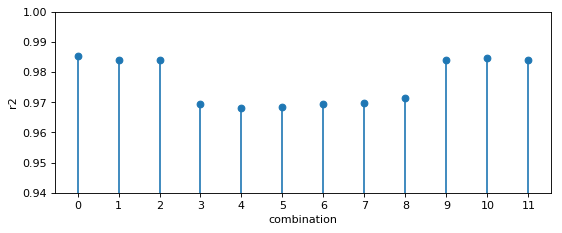

In [25]:
"""Plot max_features/n_estimators vs r2 score on validation set"""

plt.figure(figsize=(8, 3), dpi=80)
axes = plt.gca()
axes.set_ylim([0.94, 1.0])
# axes.set_xlim([0, 12])
plt.stem(r2_result_rf_df.index, r2_result_rf_df["vld_r2_rf"])
plt.xticks(np.arange(12))
plt.xlabel('combination')
plt.ylabel('r2')
plt.show()

In [26]:
"""Find the best max_features/n_estimators combination"""

rsq_max = max(r2_result_rf)
index = r2_result_rf.index(rsq_max)

print('vld_rsq maximum:', rsq_max, 'index:', index)
print('Best max_features/n_estimators:', combination_rf[index])

vld_rsq maximum: 0.985152657625807 index: 0
Best max_features/n_estimators: auto/50


In [27]:
"""Build a random forests model with the best max_features/n_estimators combination"""

rf_model = RandomForestRegressor(n_jobs=-1, max_features='auto', n_estimators=50)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

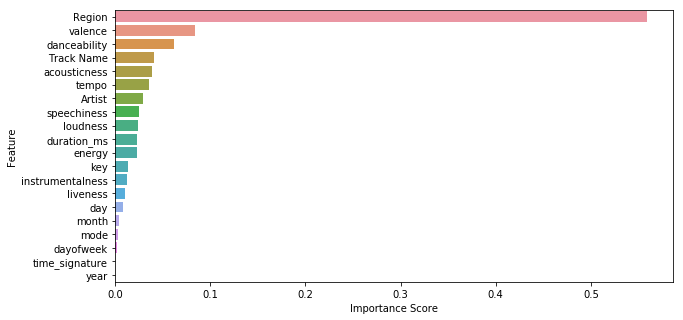

In [28]:
'''Plot importance scores of data features'''

plt.figure(figsize=(10, 5))
rf_model.feature_importances_
feat_imps = pd.DataFrame(rf_model.feature_importances_, index = X_train.columns,
            columns=['Importance score']).sort_values('Importance score', ascending=False)

feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature", "Importance Score"]
sns.barplot(x="Importance Score", y="Feature", data=feat_imps, orient="h")

In [29]:
"""Drop those columns with little importance"""

X_train_final = X_train.drop(['year', 'time_signature', 'dayofweek', 'mode', 'month'], axis=1)
X_valid_final = X_valid.drop(['year', 'time_signature', 'dayofweek', 'mode', 'month'], axis=1)

print(X_train_final.shape, X_valid_final.shape)

(330015, 15) (58238, 15)


In [30]:
"""Retrain the random forests model with ultimate training dataset"""

rf_model.fit(X_train_final, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

### - Neural Networks Model

In [32]:
"""Build a deep neural networks model"""

dnn_model = Sequential()
dnn_model.add(Dense(23, input_dim=15, kernel_initializer='normal', activation='relu'))
dnn_model.add(Dense(15, kernel_initializer='normal', activation='relu'))
dnn_model.add(Dense(9, kernel_initializer='normal', activation='relu'))
# dnn_model.add(Dense(4, kernel_initializer='normal', activation='relu'))
dnn_model.add(Dense(1, kernel_initializer='normal'))

dnn_model.compile(loss='mse', optimizer='Adam', metrics=['mse'])
history = dnn_model.fit(X_train_final, y_train, validation_data=(X_valid_final, y_valid), 
                        nb_epoch=100, batch_size=2000)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if sys.path[0] == '':
W0811 11:46:17.790971 4626138560 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0811 11:46:17.874829 4626138560 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 330015 samples, validate on 58238 samples
Epoch 1/100
330015/330015 [==============================] - 1s 2us/step - loss: 36524815610.4579 - mean_squared_error: 36524815610.4579 - val_loss: 37006329389.2675 - val_mean_squared_error: 37006329389.2675
Epoch 2/100
330015/330015 [==============================] - 0s 1us/step - loss: 35031092765.5046 - mean_squared_error: 35031092765.5046 - val_loss: 36325193846.2634 - val_mean_squared_error: 36325193846.2634
Epoch 3/100
330015/330015 [==============================] - 0s 1us/step - loss: 34946046505.1055 - mean_squared_error: 34946046505.1055 - val_loss: 36310352554.3531 - val_mean_squared_error: 36310352554.3531
Epoch 4/100
330015/330015 [==============================] - 0s 1us/step - loss: 34932956000.0616 - mean_squared_error: 34932956000.0616 - val_loss: 36300948478.8747 - val_mean_squared_error: 36300948478.8747
Epoch 5/100
330015/330015 [==============================] - 0s 1us/step - loss: 34924649225.7392 - mean_squared_

Epoch 40/100
330015/330015 [==============================] - 0s 1us/step - loss: 34717922943.8798 - mean_squared_error: 34717922943.8798 - val_loss: 36061156431.5983 - val_mean_squared_error: 36061156431.5983
Epoch 41/100
330015/330015 [==============================] - 0s 1us/step - loss: 34715842682.6262 - mean_squared_error: 34715842682.6262 - val_loss: 36046904195.2133 - val_mean_squared_error: 36046904195.2133
Epoch 42/100
330015/330015 [==============================] - 0s 1us/step - loss: 34713675773.2074 - mean_squared_error: 34713675773.2074 - val_loss: 36056367725.8236 - val_mean_squared_error: 36056367725.8236
Epoch 43/100
330015/330015 [==============================] - 0s 1us/step - loss: 34712066558.2120 - mean_squared_error: 34712066558.2120 - val_loss: 36057357498.8108 - val_mean_squared_error: 36057357498.8108
Epoch 44/100
330015/330015 [==============================] - 0s 1us/step - loss: 34708096247.4535 - mean_squared_error: 34708096247.4535 - val_loss: 3604868020

330015/330015 [==============================] - 0s 1us/step - loss: 34654793905.5027 - mean_squared_error: 34654793905.5027 - val_loss: 35992250123.8070 - val_mean_squared_error: 35992250123.8070
Epoch 80/100
330015/330015 [==============================] - 0s 1us/step - loss: 34652877072.6005 - mean_squared_error: 34652877072.6005 - val_loss: 36003268544.4813 - val_mean_squared_error: 36003268544.4813
Epoch 81/100
330015/330015 [==============================] - 0s 1us/step - loss: 34651873201.8925 - mean_squared_error: 34651873201.8925 - val_loss: 35992062752.8275 - val_mean_squared_error: 35992062752.8275
Epoch 82/100
330015/330015 [==============================] - 0s 1us/step - loss: 34649361568.9003 - mean_squared_error: 34649361568.9003 - val_loss: 35989518151.6508 - val_mean_squared_error: 35989518151.6508
Epoch 83/100
330015/330015 [==============================] - 0s 1us/step - loss: 34648106918.5747 - mean_squared_error: 34648106918.5747 - val_loss: 35994431510.6030 - val_

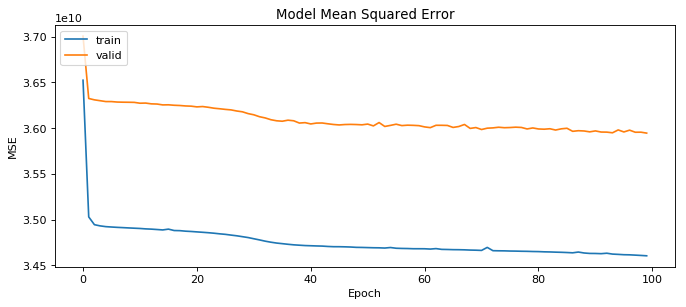

In [35]:
"""Plot epoch vs training set mse & epoch vs validation set mse"""

plt.figure(figsize=(10, 4), dpi=80)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## &#8549;. Test out Models on Test Set

In [36]:
print(X_test.shape)
X_test.head()

(52944, 24)


,Position,Track Name,Artist,URL,Date,Region,acousticness,analysis_url,danceability,duration_ms,...,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
2445480,172,Soy Peor,Bad Bunny,https://open.spotify.com/track/5MT96Zz0ymUJNm8...,2017-02-13,es,0.6790,https://api.spotify.com/v1/audio-analysis/5MT9...,0.732,257328.0,...,0.1140,-3.150,0.0,0.0860,115.942,4.0,https://api.spotify.com/v1/tracks/5MT96Zz0ymUJ...,audio_features,spotify:track:5MT96Zz0ymUJNm8obKZQr0,0.143
2445481,173,París,Dani Martín,https://open.spotify.com/track/7A6vqBPkt4rbwXs...,2017-02-13,es,0.0536,https://api.spotify.com/v1/audio-analysis/7A6v...,0.562,244587.0,...,0.1020,-6.384,1.0,0.0258,94.013,4.0,https://api.spotify.com/v1/tracks/7A6vqBPkt4rb...,audio_features,spotify:track:7A6vqBPkt4rbwXsKhrl7B1,0.307
2445482,174,El Chisme,Reykon,https://open.spotify.com/track/4VXejnj5WgM6H72...,2017-02-13,es,0.1190,https://api.spotify.com/v1/audio-analysis/4VXe...,0.723,177799.0,...,0.1710,-3.022,0.0,0.1060,92.964,4.0,https://api.spotify.com/v1/tracks/4VXejnj5WgM6...,audio_features,spotify:track:4VXejnj5WgM6H72ct2fSgQ,0.812
2445483,175,Blow Your Mind (Mwah),Dua Lipa,https://open.spotify.com/track/2eAAEa8pxKF7My0...,2017-02-13,es,0.0188,https://api.spotify.com/v1/audio-analysis/2eAA...,0.654,178583.0,...,0.0948,-4.761,0.0,0.1220,108.854,4.0,https://api.spotify.com/v1/tracks/2eAAEa8pxKF7...,audio_features,spotify:track:2eAAEa8pxKF7My0EO4rFgR,0.491
2445484,176,La Casa No Es Igual,Melendi,https://open.spotify.com/track/7yjTvUlvx7S1pne...,2017-02-13,es,0.4930,https://api.spotify.com/v1/audio-analysis/7yjT...,0.485,213240.0,...,0.1440,-5.188,0.0,0.0804,174.129,4.0,https://api.spotify.com/v1/tracks/7yjTvUlvx7S1...,audio_features,spotify:track:7yjTvUlvx7S1pneUODlGBg,0.303


<i>Next, we should preprocess test set data exactly the same way we did for training set data and 
validation set data, except that we use those maps we got earlier when converting object dtype data to numerical values.</i>

In [37]:
"""Preprocess test set data"""

# Drop columns that intuitively wouldn't be helpful 
X_test_2 = X_test.drop(['Position', 'URL', 'analysis_url', 'id', 'track_href', 'type', 'uri'], axis=1)

# Split the 'Data' column
X_test_3 = split_date(X_test_2, 'Date')

# Convert object dtype data to numerical values with those maps we got earlier
X_test_4, _ = convert_cat_to_num(X_test_3, 'Track Name', track_name_map)
X_test_4, _ = convert_cat_to_num(X_test_4, 'Artist', artist_map)
X_test_4, _ = convert_cat_to_num(X_test_4, 'Region', region_map)

# Deal with NaNs
X_test_5 = X_test_4.fillna(0)

# Standardize continuous variables
X_test_5[con_cols] = scaler.transform(X_test_5[con_cols])

# Drop columns with little importance
X_test_final = X_test_5.drop(['year', 'time_signature', 'dayofweek', 'mode', 'month'], axis=1)

X_test_final.head()

,Track Name,Artist,Region,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,day
2445480,3606,215,18,2.007973,0.537398,0.898355,-0.420280,-0.094855,-1.411199,-0.441398,1.187956,-0.165294,-0.140208,-1.667173,13
2445481,2978,487,18,-0.712287,-0.770410,0.581985,0.286964,-0.133192,1.281451,-0.534978,-0.206612,-0.803158,-0.898573,-0.937522,13
2445482,1116,1815,18,-0.427821,0.468161,-1.076419,1.505326,-0.133611,1.012186,0.003107,1.243153,0.046621,-0.934851,1.309272,13
2445483,533,588,18,-0.863654,-0.062655,-1.056951,0.714877,-0.133611,-0.872669,-0.591125,0.493259,0.216153,-0.385331,-0.118888,13
2445484,2057,1487,18,1.198942,-1.362770,-0.196388,0.043292,-0.133611,-1.411199,-0.207448,0.309128,-0.224630,1.872058,-0.955318,13


<b>Testing...</b>

In [38]:
"""Test the random forests model"""

y_vld_pre_rf = rf_model.predict(X_valid_final)
r2_trn_rf = r2_score(y_valid, y_vld_pre_rf)
mse_trn_rf = mean_squared_error(y_valid, y_vld_pre_rf)

y_tst_pre_rf = rf_model.predict(X_test_final)
r2_tst_rf = r2_score(y_test, y_tst_pre_rf)
mse_tst_rf = mean_squared_error(y_test, y_tst_pre_rf)

print('Random Forests Model:')
print('r2 on training set:', r2_trn_rf)
print('mse on training set:', mse_trn_rf)
print('r2 on test set:', r2_tst_rf)
print('mse on test set:', mse_tst_rf)

Random Forests Model:
r2 on training set: 0.9245910505221738
mse on training set: 2712325125.631889
r2 on test set: 0.8692892867567441
mse on test set: 5351882934.220665


In [39]:
"""Test the neural networks model"""

y_vld_pre_dnn = dnn_model.predict(X_valid_final)
r2_trn_dnn = r2_score(y_valid, y_vld_pre_dnn)
mse_trn_dnn = mean_squared_error(y_valid, y_vld_pre_dnn)

y_tst_pre_dnn = dnn_model.predict(X_test_final)
r2_tst_dnn = r2_score(y_test, y_tst_pre_dnn)
mse_tst_dnn = mean_squared_error(y_test, y_tst_pre_dnn)

print('Neural Networks Model:')
print('r2 on training set:', r2_trn_dnn)
print('mse on training set:', mse_trn_dnn)
print('r2 on test set:', r2_tst_dnn)
print('mse on test set:', mse_tst_dnn)

Neural Networks Model:
r2 on training set: 0.0005947667409340607
mse on training set: 35946819888.448944
r2 on test set: 0.0010583078515803424
mse on test set: 40901153867.48132
